In [1]:
import keras
from keras.models import Sequential
from keras.layers import Rescaling
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
 
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt

print(K._get_available_gpus())


[]


In [2]:
batch_size = 32
num_classes = 5
epochs = 20

# path: save model
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'coral_reef_cnn.h5'

# path for inputs
path = os.getcwd() + '/data/clean/split/on-func/'
train_folder = path + 'train'
test_folder = path + 'test'
val_folder = path + 'valid'


In [3]:

# normalization layer -> rescaling rgb img in range [0,1]
normalization_layer = Rescaling(1./255)

# train dataset
train_ds = keras.utils.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    image_size=(100, 100),
    batch_size = batch_size,
    shuffle=True
)
train_ds_norm = train_ds.map(lambda x, y: (normalization_layer(x), y))

# test dataset
test_ds = keras.utils.image_dataset_from_directory(
    test_folder,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    image_size=(100, 100),
    batch_size = batch_size,
    shuffle=True
)
test_ds_norm = test_ds.map(lambda x, y: (normalization_layer(x), y))

# val dataset
val_ds = keras.utils.image_dataset_from_directory(
    val_folder,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    image_size=(100, 100),
    batch_size = batch_size,
    shuffle=True
)
val_ds_norm = val_ds.map(lambda x, y: (normalization_layer(x), y))

class_names = train_ds.class_names
print(class_names)


Found 7000 files belonging to 5 classes.
Found 2550 files belonging to 5 classes.
Found 450 files belonging to 5 classes.
['Algae', 'Hard Coral', 'Other', 'Other Invertebrates', 'Soft Coral']


In [4]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(100,100,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))       
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.35))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model


In [5]:
model = cnn_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                        

In [6]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

# metrics
metrics = ['accuracy',
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall')
           ]

# compile
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=metrics)


In [7]:
history = model.fit(train_ds_norm,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_ds_norm),
                    shuffle=True)


Epoch 1/20
219/219 [==============================] - 38s 167ms/step - loss: 1.4588 - accuracy: 0.3290 - precision: 0.7371 - recall: 0.0793 - val_loss: 1.4171 - val_accuracy: 0.3494 - val_precision: 0.8431 - val_recall: 0.0675
Epoch 2/20
219/219 [==============================] - 35s 160ms/step - loss: 1.3815 - accuracy: 0.3673 - precision: 0.7403 - recall: 0.1221 - val_loss: 1.3930 - val_accuracy: 0.3647 - val_precision: 0.6974 - val_recall: 0.1365
Epoch 3/20
219/219 [==============================] - 34s 156ms/step - loss: 1.3574 - accuracy: 0.3933 - precision: 0.7234 - recall: 0.1300 - val_loss: 1.3689 - val_accuracy: 0.3820 - val_precision: 0.7228 - val_recall: 0.1380
Epoch 4/20
219/219 [==============================] - 35s 159ms/step - loss: 1.3316 - accuracy: 0.4021 - precision: 0.7274 - recall: 0.1369 - val_loss: 1.3375 - val_accuracy: 0.3996 - val_precision: 0.7884 - val_recall: 0.1227
Epoch 5/20
219/219 [==============================] - 36s 162ms/step - loss: 1.3084 - accura

In [8]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

#print(history.history)


Saved trained model at c:\Users\eric_\Documents\GitHub\fruitpunch_coral_classification\saved_models\coral_reef_cnn.h5 


In [9]:
score = model.evaluate(val_ds_norm, verbose=1)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


15/15 [==============================] - 1s 44ms/step - loss: 1.5641 - accuracy: 0.4511 - precision: 0.5159 - recall: 0.3600
[1.5640681982040405, 0.4511111080646515, 0.5159235596656799, 0.36000001430511475]
Test loss: 1.5640681982040405
Test accuracy: 0.4511111080646515


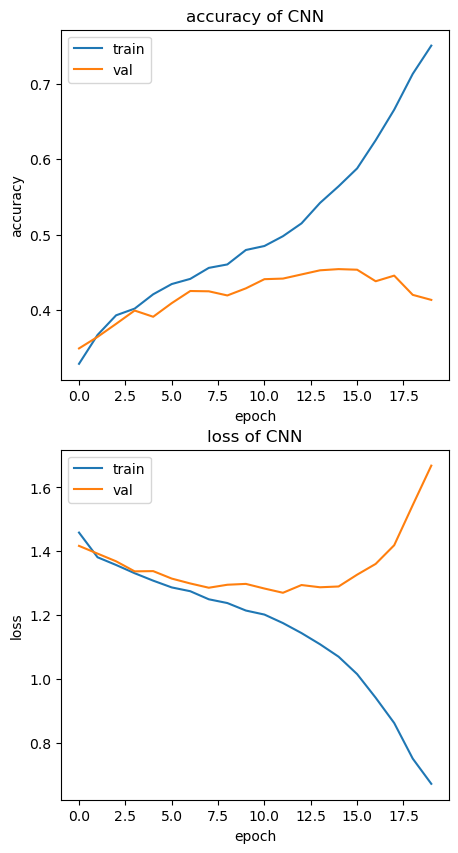

In [10]:
fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(*[2,1,1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
ax.set_title('accuracy of CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

ax = fig.add_subplot(*[2,1,2])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss of CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()